1\. **2D minimization of a six-hump camelback function**

$$f(x,y) = \left(4-2.1x^2+\frac{x^4}{3} \right) x^2 +xy + (4y^2 -4)y^2$$

has multiple global and local minima.

- Find the global minima of this function
- How many global minima are there, and what is the function value at those points?
- What happens for an initial guess of $(x, y) = (0, 0)$?

Hints:

* Variables can be restricted to $-2 < x < 2$ and $-1 < y < 1$.
* Use `numpy.meshgrid()` and `pylab.imshow()` to find visually the regions.
* Use `scipy.optimize.minimize()`, optionally trying its optional arguments.

Minimization result: [ 0.08984201 -0.71265642] starting from [-0.5, -0.5]
Minimization result: [-0.08984254  0.71265644] starting from [-0.5, 0.75]
Minimization result: [0. 0.] starting from [0, 0]
Values of the function in correspondance of the two global minima: -1.0316284534898759 -1.0316284534888045
Value of the function in correspondance of the origin: 0.0


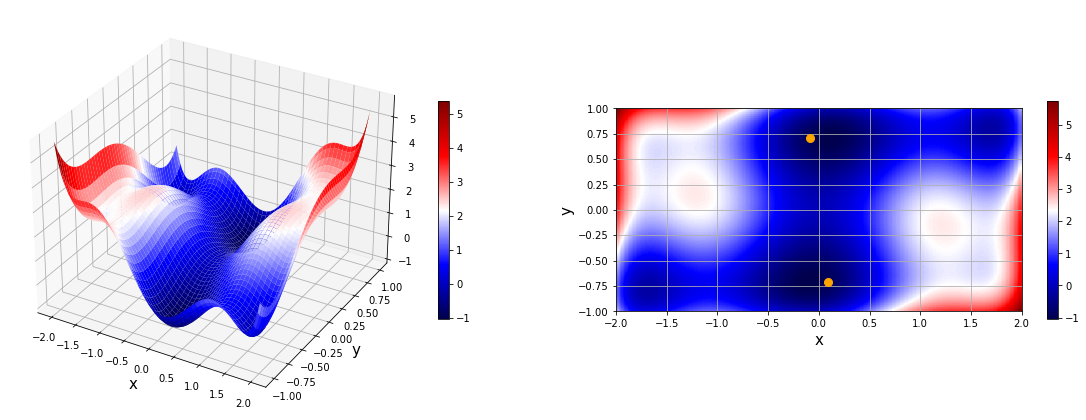

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from scipy import optimize
from mpl_toolkits.mplot3d import Axes3D

def f(p):
    x, y = p
    return (4 - 2.1*x**2 + x**4/3)*x**2 + x*y + (4*y**2 - 4)*y**2 
  
x = np.linspace(-2, 2, 100)
y = np.linspace(-1, 1, 100)
xf, yf = np.meshgrid(x, y)
l = [xf, yf]
z = f(l)

fig = plt.figure(figsize=(20,20))
ax = fig.add_subplot(1,2,1, projection='3d')
plt.xlabel('x',fontsize=15)
plt.ylabel('y', fontsize=15)
surface = ax.plot_surface(xf, yf, z, cmap = cm.seismic)
fig.colorbar(surface, shrink=0.2)

ax = fig.add_subplot(1,2,2)
ax.grid()
ax.set_xlabel('x', fontsize=15)
ax.set_ylabel('y', fontsize=15)
cb = ax.imshow(z, extent=[-2, 2, -1, 1], cmap = cm.seismic)
fig.colorbar(cb, shrink=0.2)

# MINIMIZATION ---------------------------------------------------------------------------------------------------
initial_guess = [-0.5, -0.5]
result1 = optimize.minimize(f, initial_guess)
if(result1['success'] == True):
    print("Minimization result:", result1['x'], "starting from", initial_guess)
    
initial_guess = [-0.5, 0.75]
result2 = optimize.minimize(f, initial_guess)
if(result2['success'] == True):
    print("Minimization result:", result2['x'], "starting from", initial_guess)
    
initial_guess = [0, 0]
result3 = optimize.minimize(f, initial_guess)
if(result3['success'] == True):
    print("Minimization result:", result3['x'], "starting from", initial_guess)
# ----------------------------------------------------------------------------------------------------------------
  
ax.plot(result1['x'][0], result1['x'][1], marker='o', markersize=8, color='orange')
ax.plot(result2['x'][0], result2['x'][1], marker='o', markersize=8, color='orange')

l1 = [result1['x'][0], result1['x'][1]]
l2 = [result2['x'][0], result2['x'][1]]
l3 = [result3['x'][0], result3['x'][1]]

print("Values of the function in correspondance of the two global minima:", f(l1), f(l2))
print("Value of the function in correspondance of the origin:", f(l3))

#The function has two global minima, located in correspondance of the orange dots in the 2d graph.
#Since the function is symmetrical, the value in the two global minima is the same. This is also the reason
#why, with the origin as the starting point, the algorithm doesn't know what global minima to converge to, and 
#doesn't find the correct result

2\. **Curve fitting of temperature in Alaska** 

The temperature extremes in Alaska for each month, starting in January, are given by (in degrees Celcius):

max:  `17,  19,  21,  28,  33,  38, 37,  37,  31,  23,  19,  18`

min: `-62, -59, -56, -46, -32, -18, -9, -13, -25, -46, -52, -58`

* Plot these temperatures.
* Find a suitable a function that can describe min and max temperatures. 
* Fit this function to the data with `scipy.optimize.curve_fit()`.
* Plot the result. Is the fit reasonable? If not, why?
* Is the time offset for min and max temperatures the same within the fit accuracy?

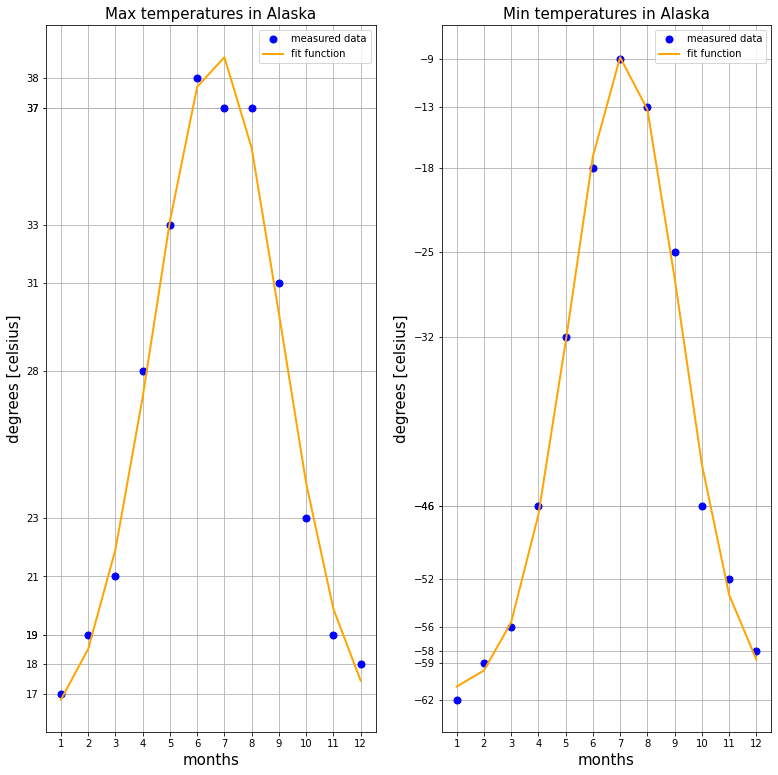

In [2]:
from math import pi

#The guess is a gaussian function because the data points in both situations clearly reflect a gaussian shape.
#The parameters to estimate are the amplitude, the mean, the std dev and the offset
def gaussian(a, amp, mean, std, offset):
    return amp*np.exp(-0.5*((a - mean)/std)**2) + offset


maximum = np.array([17, 19, 21,  28,  33,  38, 37,  37,  31,  23,  19,  18])
minimum = np.array([-62, -59, -56, -46, -32, -18, -9, -13, -25, -46, -52, -58])
x = np.arange(1,13)

fig = plt.figure(figsize=(13,13))
ax = fig.add_subplot(1,2,1)
ax.set_title('Max temperatures in Alaska', fontsize=15)
ax.set_xticks(x)
ax.set_xlabel('months', fontsize=15)
ax.set_yticks(maximum)
ax.set_ylabel('degrees [celsius]', fontsize=15)
ax.plot(x, maximum, 'o', color='blue', markersize=7, label='measured data')
ax.grid()

popt, pcov = optimize.curve_fit(gaussian, x, maximum, p0=[20,7,1,17])
ax.plot(x, gaussian(x, popt[0], popt[1], popt[2], popt[3]), color='orange', linewidth=2, label='fit function')
ax.legend()

ax = fig.add_subplot(1,2,2)
ax.set_title('Min temperatures in Alaska', fontsize=15)
ax.set_xticks(x)
ax.set_xlabel('months', fontsize=15)
ax.set_yticks(minimum)
ax.set_ylabel('degrees [celsius]', fontsize=15)
ax.plot(x, minimum, 'o', color='blue', markersize=7, label='measured data')
ax.grid()

popt, pcov = optimize.curve_fit(gaussian, x, minimum, p0=[50,7,1,-62])
ax.plot(x, gaussian(x, popt[0], popt[1], popt[2], popt[3]), color='orange', linewidth=2, label='fit function')
ax.legend()
plt.show()

#The fit seems reasonable in both cases, in particular for the min temperatures case

3\. **Fit the residues**

Read the `data/residuals_261.pkl` file. If you haven't it already, download it from here:

```bash
wget https://www.dropbox.com/s/3uqleyc3wyz52tr/residuals_261.pkl -P data/
```

The feature name "residual" contains the residuals (defined as $y_i - \hat{y}_i$) of a linear regression as a function of the independent variable "distances".

- Considering only the "residual" feature, create an histogram with the appropriate binning and display it.
- Set the appropriate Poisson uncertainty for each bin (thus, for each bin, $\sigma_i = \sqrt{n_i}$, where $n_i$ is the number of entries in each bin)
- By looking at the distribution of the residuals, define an appropriate function and fit it to the histogram of the residuals
- Perform a goodness-of-fit test. Is the p-value of the fit satisfactory?

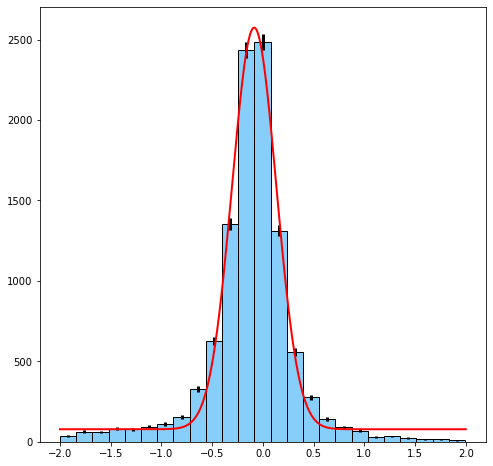

pvalue:  0.0  so the fit is not satisfactory


In [3]:
import pandas as pd
from scipy import stats

def gaussian(a, amp, mean, std, offset):
    return amp*np.exp(-0.5*((a - mean)/std)**2) + offset


filename = "data/residuals_261.pkl"
arr = np.load(filename, allow_pickle=True).item()
df = pd.DataFrame(arr)

filtered_df = df[abs(df['residuals']) < 2]   #as for 07ex

nbin = 25

fig, ax = plt.subplots(figsize=(8,8))
h, bins, _ = ax.hist(filtered_df['residuals'], histtype='bar', bins=nbin, density=False, color='lightskyblue', edgecolor='black')
centers = (bins[1:] + bins[:-1])*0.5
uncertainties = np.sqrt(h)
ax.errorbar(centers, h, yerr = uncertainties, ls='none', linewidth=3, c='black')

popt, pcov = optimize.curve_fit(gaussian, centers, h, p0=[max(h),0,1,min(h)])
x = np.linspace(-2,2,1000)
fit_function = gaussian(x, popt[0], popt[1], popt[2], popt[3])
ax.plot(x, fit_function, color='red', linewidth=2, label='fit function')
plt.show()

#pvalue test
dof = len(centers) - 1
chi2 = np.sum((h - gaussian(centers, popt[0], popt[1], popt[2], popt[3]))**2 / uncertainties**2)
pvalue = 1. - stats.chi2.cdf(chi2, dof)

print("pvalue: ", round(pvalue,4), " so the fit is not satisfactory")

4\. **Temperatures in Munich**

Get the following data file:

```bash
https://www.dropbox.com/s/7gy9yjl00ymxb8h/munich_temperatures_average_with_bad_data.txt
```

which gives the temperature in Munich every day for several years.


Fit the following function to the data:

$$f(t) = a \cos(2\pi t + b)+c$$

where $t$ is the time in years.

- Make a plot of the data and the best-fit model in the range 2008 to 2012.

   - What are the best-fit values of the parameters?

   - What is the overall average temperature in Munich, and what are the typical daily average values predicted by the model for the coldest and hottest time of year?

   - What is the meaning of the $b$ parameter, and what physical sense does it have?


- Now fit the data with the function $g(x)$, which has 1 more parameter than $f(x)$.
$$g(x) = a \cos(2\pi b t + c)+d$$
   - What are the RSS for $f(x)$ and $g(x)$?
   - Use the Fisher F-test to determine whether the additional parameter is motivated.

Best-fit values of the parameters: [-9.96203468 -0.23462776  9.26282131]
Overall average temperature in Munich: 9.261252084167237
The max temperature predicted by the model is: 19.224753437613607
The min temperature predicted by the model is: -0.6990214824543539
The parameter b represents the phase constant, and it is associated to a shift along the x axis.
If we change it, the cosine will of course not fit the data anymore
It's clear that the additional parameter is not motivated: the two fit functions overlap almost perfectly

RSS for f(x):  18669.515394578364
RSS for g(x):  18669.225430609215
CL: 0.880 , additional parameter necessary: NO


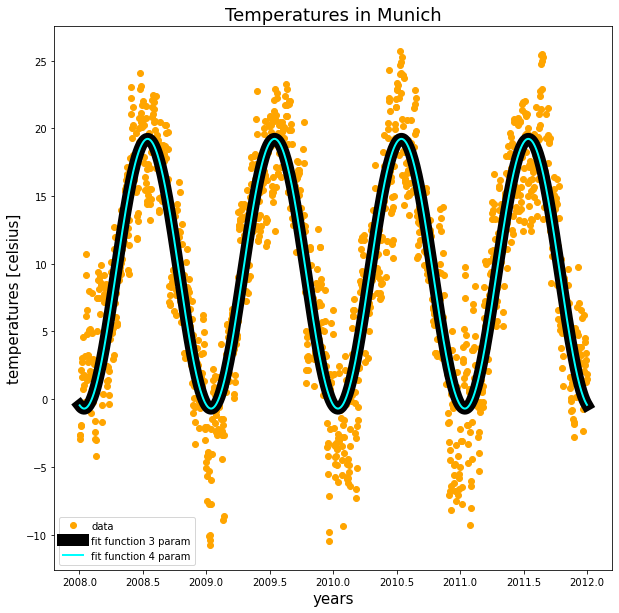

In [4]:
from math import pi

def fun(t, a, b, c):
    return a * np.cos(2*pi*t + b) + c

def fun2(t, a, b, c, d):
    return a * np.cos(2*pi*b*t + c) + d

def Ftest(ssr_1, ssr_2, ndof_1, ndof_2, nbins, verbose=False):
    F = ((ssr_1 - ssr_2)/(ndof_2 - ndof_1)) / (ssr_2/(nbins - ndof_2))
    CL = 1. - stats.f.cdf(F, ndof_2 - ndof_1, nbins - ndof_2)
    if verbose: print("CL: %.3f" % CL, ", additional parameter necessary:", "YES" if CL < 0.10 else "NO")
    return CL

filename = "data/munich_temperatures_average_with_bad_data.txt"

char = []
years = []
temp = []

with open(filename, mode='r') as f:
    for line in f:
        for c in line.rstrip('\n').split(' '):  #rstrip eliminates the new line character at the end of each line
            char.append(c)
        if(float(char[0]) >= 2008 and float(char[0]) <= 2012):    
            years.append(char[0])
            temp.append(char[1])
        char.clear()
            
#converting the two lists of strings into two lists of doubles and then into np.array
t = map(float, temp)
y = map(float, years)
temperatures = np.array(list(t))
years = np.array(list(y)) 

#removing temperatures higher than 60 degree (there were two outliers in the dataset)
indexes = [i for i in range(len(temperatures)) if temperatures[i] > 60]
temperatures = np.delete(temperatures, indexes)
years = np.delete(years, indexes)

fig, ax = plt.subplots(figsize=(10,10))
ax.plot(years, temperatures, 'o', label='data', color='orange')
ax.set_xlabel('years', fontsize=15)
ax.set_ylabel('temperatures [celsius]', fontsize=15)
ax.set_title('Temperatures in Munich', fontsize=18)

popt, pcov = optimize.curve_fit(fun, years, temperatures, p0=[15,0,0])
model_values = fun(years, popt[0], popt[1], popt[2])
ax.plot(years, model_values, color='black', linewidth=12, label='fit function 3 param')
ax.grid()
model_values = fun(years, popt[0], popt[1], popt[2])

popt2, pcov2 = optimize.curve_fit(fun2, years, temperatures, p0=[15,1,0,0])
ax.plot(years, fun2(years, popt2[0], popt2[1], popt2[2], popt2[3]), c='cyan', lw=2, label='fit function 4 param')
ax.legend()
ax.grid()

print("Best-fit values of the parameters:", popt)
print("Overall average temperature in Munich:", np.mean(temperatures))
print("The max temperature predicted by the model is:", max(model_values))
print("The min temperature predicted by the model is:", min(model_values))
print("The parameter b represents the phase constant, and it is associated to a shift along the x axis.")
print("If we change it, the cosine will of course not fit the data anymore")
print("It's clear that the additional parameter is not motivated: the two fit functions overlap almost perfectly")

model_values = fun(years, popt[0], popt[1], popt[2])

#Fisher test
RSSf = np.sum((fun(years, popt[0], popt[1], popt[2]) - temperatures)**2) 
RSSg = np.sum((fun2(years, popt2[0], popt2[1], popt2[2], popt2[3]) - temperatures)**2) 

print("\nRSS for f(x): ", RSSf)
print("RSS for g(x): ", RSSg)

result = Ftest(RSSf, RSSg, 2, 3, len(years), verbose=True)